In [2]:
from keras.models import load_model
from keras.applications.mobilenet_v2 import preprocess_input
from keras.preprocessing.image import image_utils
import cv2 as cv
from typing import Union
import numpy as np
from PIL import ImageFont, ImageDraw, Image
import matplotlib.pyplot as plt

In [3]:
PROTO_FACE_DETECT_PATH = "models/face_detec.prototxt"
MODEL_FACE_DETECT_PATH = "models/model_face.h5"
MODEL_MASK_DETECT_PATH = "models/model_mask.h5"

face_net = cv.dnn.readNet(PROTO_FACE_DETECT_PATH, MODEL_FACE_DETECT_PATH)
mask_net = load_model(MODEL_MASK_DETECT_PATH)

In [4]:
def predict_mask(frame, face_net, mask_net) -> Union[list, list]:
  (h, w)= frame.shape[:2]
  blob = cv.dnn.blobFromImage(
    frame,
    1.0,
    (224,224),
    (104.0, 177.0, 123.0))
  face_net.setInput(blob)
  detections = face_net.forward()

  faces=[]
  locs=[]
  preds=[]
    
  for i in range(0, detections.shape[2]):
    confidence = detections[0,0,i,2]
    if confidence>0.5:
      box = detections[0,0,i,3:7]*np.array([w,h,w,h])
      (startX, startY, endX, endY)= box.astype("int")
          
      (startX, startY) = (max(0, startX), max(0, startY))
      (endX, endY) = (min(w-1, endX), min(h-1, endY))
          
      face = frame[startY:endY, startX:endX]
      face = cv.cvtColor(face, cv.COLOR_BGR2RGB)
      face = cv.resize(face, (224,224))
      face = image_utils.img_to_array(face)
      face = preprocess_input(face)
          
      faces.append(face)
      locs.append((startX, startY, endX, endY))
    
  if len(faces)>0:
    faces = np.array(faces, dtype="float32")
    preds = mask_net.predict(faces, batch_size=32)
        
  return (locs, preds)

In [5]:
def debug_imshow(image):
  fig = plt.figure(figsize=(4, 3), dpi=100)
  plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
  plt.show()

1/1 [==============================] - 1s 1s/step


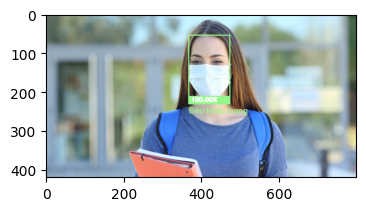

In [6]:
image_path = 'static/test-9.jpg'
image_cv = cv.imread(image_path)
(locs, preds) = predict_mask(image_cv, face_net=face_net, mask_net=mask_net)
for (box, pred) in zip(locs, preds):
  (startX, startY, endX, endY) = box
  (mask, withoutMask) = pred
  
  label = ""
  color = (255, 255, 255)
  if mask > withoutMask:
    label = "Đeo khẩu trang"
    color = (139, 247, 149)
  else:
    label = "Không đeo khẩu trang"
    color = (73, 92, 255)
        
  fontpath = "static/pro.ttf"
  font = ImageFont.truetype(fontpath, 20)
  img_pil = Image.fromarray(image_cv)
  draw = ImageDraw.Draw(img_pil)
  draw.text((startX, endY+5), label, font = font, fill = color)
  image_cv = np.array(img_pil)

  cv.rectangle(image_cv, (startX, startY), (endX, endY), color, 2)

  cv.rectangle(image_cv, (startX, endY - 20), (endX, endY), color, cv.FILLED)
  cv.putText(image_cv, "{:.2f}%".format(max(mask, withoutMask)*100), (startX + 6, endY - 6), cv.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255),2)
cv.imwrite('out.jpg', image_cv)
debug_imshow(image_cv)